Aiming to bring together everything (that can be done on 4 cores) into a single notebook, to reduce the mental load of juggling things into a single paper. The dumping of ty-trans and pot_rho_2 to scratch, calculating overturning and calculating mascon averages is still external. This notebook will include fitting weights, and all the "showing accuracy" results style plots. (Final result is local because that's where the JPL data is)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/g/data/x77/jj8842/')
sys.path.append('/g/data/x77/jj8842/results')
import cosimagrace as cg
import default as df

0.3.0


In [3]:
mm = 1/25.4
plt.figure()
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 200
h = ('...','+++','///')
plt.rcParams.update({'hatch.linewidth': 0.8})

<Figure size 640x480 with 0 Axes>

In [4]:
transect_ids = (0,1,2,3,4,5,6,14,15)
basin_sets = ((14,15),(0,1),(2,3),(14,))

In [5]:
weight_names = ('paper/JPL_noisy_','paper/JPL_','paper/1deg_')
mascon = ('JPL',            'JPL',       'ACCESS_1deg')
noise = (df.JPL_sigma,       0,           0)
revive = False #Should remove later but I need to check I'm not going insane
showcase_ti = 14

#### Fit the weights that we need for finals here

In [6]:
for i in range(3):
    cg.automated_linear_regression(weight_names[i],
                                transect_ids, 
                                mascon[i],
                                remove_climatology_bool = True,
                                ocean_cutoff=df.ocean_cutoff,
                                remove_climatology_test = True,
                                data_version = 'data_v4',
                                overturning = '_hr_overturning.nc',
                                overturning_var = 'ty_trans_rho',
                                NS_extent = df.NS_extent,
                                modify_x = (df.filters[df.fi],lambda x: df.filters[df.fi](x)+1),
                                modify_y = (df.filters[df.fi],df.filters[df.fi]),
                                test_modify_x = None,
                                test_modify_y=None,
                                revive=revive,
                                test_score = lambda x,y,c: cg.noisy_filtered_R2(x,y,c,noise[i],df.filters[df.fi],df.window_func[df.fi]),
                                description = '')

Writing an empty weights file for transect id:  6
Writing an empty weights file for transect id:  15
Writing an empty weights file for transect id:  6
Writing an empty weights file for transect id:  15
Writing an empty weights file for transect id:  6
Writing an empty weights file for transect id:  15


### Showcase some examples from these

In [6]:
#Pretty much what I have in cosimagrace but I'm tweaking the function here for optimum presentation
def plot_mascon_weights(transect_id, data_version, name_string = '', mascon_name = '', bathymetry = True, save_loc = '/g/data/x77/jj8842/',vlim = None,cbar_ax = None):
    '''Plot the weights calculated in the linear regression so I can see the spacial distribution'''
    
    weights = xr.load_dataset(save_loc+data_version+'/'+"{:02d}".format(int(transect_id))+'/'+name_string+'weights.nc').weights/1037/10**6
    plot_mascon = np.array(xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').primary_mascon,int)
    xt_ocean = xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').xt_ocean
    yt_ocean = xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').yt_ocean
    transect = xr.load_dataset(save_loc+data_version+'/transect_definitions.nc').sel(id = transect_id)
    
    full_weights = np.zeros(np.max(plot_mascon)+1)
    full_weights[:] = np.nan
    full_weights[weights.mc] = weights
    gridded_weights = full_weights[plot_mascon].T
    
    mascon_centres = xr.load_dataset(save_loc+'mascon_definitions/centres_'+mascon_name+'.nc').sel(mc=weights.mc)
    lons = np.array((np.min(mascon_centres.lons)-2,np.max(mascon_centres.lons)+2))
    lons[lons>80] = lons[lons>80]-360
    lats = np.array((np.min(mascon_centres.lats-2),np.max(mascon_centres.lats+2)))
    
    
    if vlim is None:
        vlim = np.max((np.max(weights),-np.min(weights)))
    c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True
                  )
    if cbar_ax is None:
        cbar = plt.colorbar(c,extend='both')
    else:
        cbar = plt.colorbar(c,extend='both',ax=cbar_ax,fraction = 1)
    cbar.set_label('Weight\n(Sv/dbar)')
        
    plt.xlim(lons)
    plt.ylim(lats)
    
    bathymetry = cg.get_bathymetry()
    local_bath = bathymetry.sel(xt_ocean = slice(lons[0],lons[1]),yt_ocean = slice(lats[0],lats[1]))
    plt.contour(local_bath.xt_ocean,local_bath.yt_ocean,local_bath,np.arange(0,5000,1000),colors='k',linewidths=0.4,alpha=0.5)
    c3000 = plt.contour(local_bath.xt_ocean,local_bath.yt_ocean,local_bath.where((local_bath.xt_ocean+local_bath.yt_ocean<-210) | (local_bath.xt_ocean<-175)),[3000],colors='k',linewidths=0.6)
    labels = plt.gca().clabel(c3000,manual=((-177.8,-45),),fontsize=6,fmt={3000:'3000m'})
    labels[0].set_bbox(dict(facecolor='white',edgecolor='None', alpha=0.5,boxstyle='round,pad=0.2'))
    land = np.array(local_bath)
    land[np.where(np.isnan(local_bath))] = -100
    plt.contourf(local_bath.xt_ocean,local_bath.yt_ocean,land,(-200,0),colors='k')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.tight_layout()
    return c

0.8805749187646843
0.7485962206250762


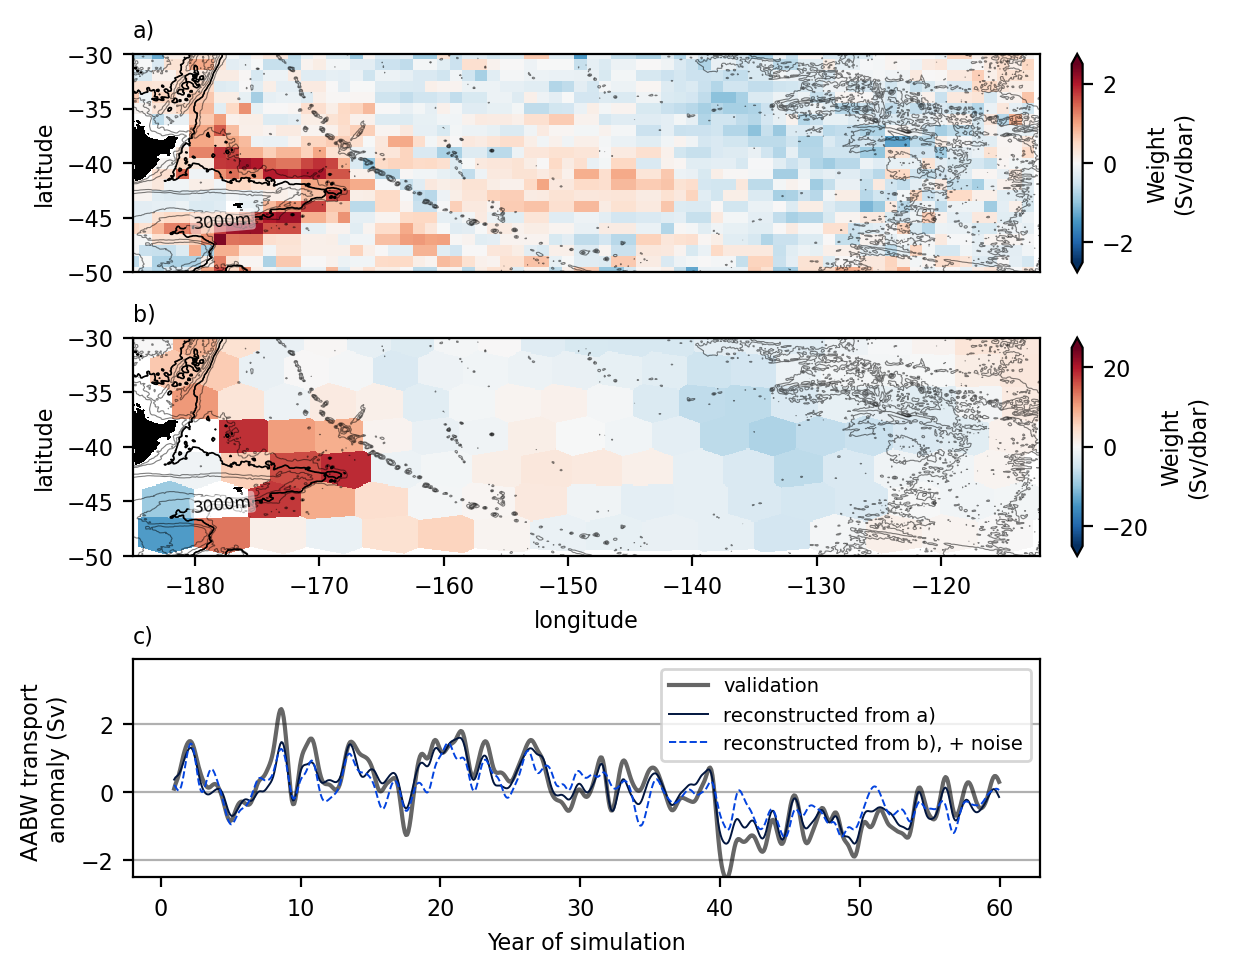

In [14]:
legends = ('reconstructed from b), + noise', 'empty','reconstructed from a)')
filename = 'hr_examples.pdf'
linestyle = ('dashed','dotted','solid')
linecolor = ('xkcd:blue','xkcd:gold','xkcd:navy')
ti=14

fig = plt.figure(figsize=(160*mm,120*mm))
ax = fig.subplots(3,2,gridspec_kw={'width_ratios':(0.85,0.15)})

#Plot both sets of weights
for ii, i in enumerate((2,0)):
    plt.sca(ax[ii,0])
    plot_mascon_weights(ti,'data_v4',weight_names[i],mascon[i],vlim=vlims[i],cbar_ax = ax[ii,1])
    plt.ylim(-50,-30)
    plt.xlim(-185,-112)


# Plot the accuracies
plt.sca(ax[2,0])
lines = []
#Validation AABW
X,Y,mc = cg.get_pbot_and_overturning(ti,df.ACCESS_OM2_01, 'JPL' , df.remove_climatology, 'data_v4',
                                         NS_extent=df.NS_extent,ocean_cutoff=df.ocean_cutoff,
                                        overturning = '_hr_overturning.nc')
Y = Y/1037/10**6
lines.append(plt.plot(cg.low_pass(np.arange(len(Y))/12,24),cg.low_pass(Y,24),'k',label='validation',zorder=2,alpha=0.6,linewidth=1.5)[0])

for ii, i in enumerate((2,0)):

    weights = np.array(xr.load_dataset('/g/data/x77/jj8842/data_v4/{:02d}/'.format(ti)+weight_names[i]+'weights.nc').weights)/1037/10**6

    X,Y,mc = cg.get_pbot_and_overturning(ti,df.ACCESS_OM2_01, mascon[i], df.remove_climatology, 'data_v4',
                                         NS_extent=df.NS_extent,ocean_cutoff=df.ocean_cutoff,
                                        overturning = '_hr_overturning.nc')
    Y = Y/1037/10**6
    

    lines.append(plt.plot(cg.low_pass(np.arange(len(Y))/12,24),cg.low_pass(weights@(X+np.random.normal(0,noise[i],X.shape)).T,24),
             linecolor[i],label=legends[i],linewidth=0.7,linestyle=linestyle[i])[0])



    print(cg.noisy_filtered_R2(X,Y,weights,noise[i],df.filters[df.fi],df.window_func[df.fi]))

plt.legend(fontsize=7)


#Pretty admin
ax[0, 1].axis('off')
ax[1, 1].axis('off')
ax[2, 1].axis('off')

ax[0,0].set_xticks([])
ax[0,0].set_xlabel('')

ax[0,0].set_title('a)',loc='left',fontsize=df.titlefontsize)
ax[1,0].set_title('b)',loc='left',fontsize=df.titlefontsize)
ax[2,0].set_title('c)',loc='left',fontsize=df.titlefontsize)

ax[2,0].grid(axis='y')
ax[2,0].set_ylabel('AABW transport \nanomaly (Sv)')
ax[2,0].set_xlabel('Year of simulation')
ax[2,0].set_ylim(-2.5, 3.9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
ax2_loc = ax[2,0].get_position()
ax2_loc.y0 = ax2_loc.y0-0.04
ax2_loc.y1 = ax2_loc.y1-0.04
ax[2,0].set_position(ax2_loc)

#ax[2,1].legend(handles=lines,fontsize=6)

plt.savefig('/g/data/x77/jj8842/results/images/'+filename,bbox_inches='tight')

### Find R$^2$ and RMSE in each ocean basin for each of those situations

In [6]:
def XYweights_basinset(expt,bs,weights_name,mascon,overturning = '_hr_overturning.nc'):
    weights_l = []
    Y = 0
    X_l = []
    mc_l = []
    
    for ti in bs:
        weights_l.append(xr.load_dataset(df.saveloc+'data_v4/{:02d}/'.format(ti)+weights_name+'weights.nc').weights)
        X0,Y0,mc0 = cg.get_pbot_and_overturning(ti,expt, mascon, df.remove_climatology, 'data_v4',NS_extent=df.NS_extent,
                                            ocean_cutoff=df.ocean_cutoff,overturning=overturning )
        X_l.append(X0)
        mc_l.append(mc0)
        Y+=Y0
    weights = np.array(xr.concat(weights_l,'mc').sortby('mc'))
        
    X = np.concatenate(X_l,1)[:,np.argsort(xr.concat(mc_l,'mc').mc)]
    return X,Y,weights

In [8]:
R_mascon = {}

for i in range(3):
    for bs in basin_sets:
        X,Y,weights = XYweights_basinset(df.ACCESS_OM2_01, bs, weight_names[i],mascon[i])
        
        R_mascon[('r2',i,bs)] = cg.noisy_filtered_R2(X,Y,weights,noise[i],df.filters[df.fi],df.window_func[df.fi])
        R_mascon[('rmse',i,bs)] = cg.noisy_filtered_RMSE(X,Y,weights,noise[i],df.filters[df.fi],df.window_func[df.fi])/1037/10**6
        

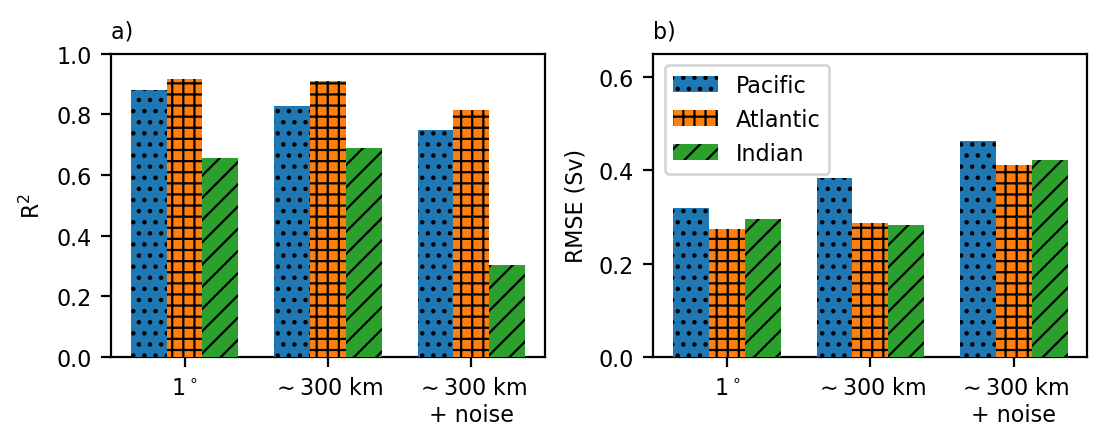

In [9]:
fig, ax = plt.subplots(1,2,figsize=(160*mm,50*mm), sharex=True)
width = 1/4
for ri, rtype in enumerate(('r2','rmse')):
    plt.sca(ax[ri])
    for bsi, bs in enumerate(basin_sets[:3]):
        plt.bar(np.arange(3)+bsi*width,
                [R_mascon[(rtype,i,bs)] for i in range(2,-1,-1)],
                label=df.wb_names[bsi],width=width,linestyle='None',hatch=h[bsi],zorder=5)
    plt.xticks(np.array([0,1,2])+width,['1$^\circ$','$\sim$300 km','$\sim$300 km\n+ noise'])
        
ax[0].set_title('a) ',loc='left',fontsize=df.titlefontsize)
ax[0].set_ylabel('R$^2$')
ax[0].set_ylim(0,1)
ax[1].set_title('b) ',loc='left',fontsize=df.titlefontsize)    
ax[1].set_ylim(0,0.65)
ax[1].set_ylabel('RMSE (Sv)')
plt.subplots_adjust(wspace=0.25)
plt.legend()
plt.savefig('/g/data/x77/jj8842/results/images/hr_mascon_grid.pdf')

In [10]:
for ri, rtype in enumerate(('r2','rmse')):
    for bsi, bs in enumerate(basin_sets[:3]):
        print(df.wb_names[bsi]+" "+rtype+":"+str(np.round([R_mascon[(rtype,i,bs)] for i in range(2,-1,-1)],3)))
    #     plt.bar(np.arange(3)+bsi*width,
    #             [R_mascon[(rtype,i,bs)] for i in range(2,-1,-1)],
    #             label=df.wb_names[bsi],width=width,linestyle='None',hatch=h[bsi],zorder=5)
print(['1 degree','JPL shapes','JPL + noise'])

Pacific r2:[0.881 0.826 0.748]
Atlantic r2:[0.918 0.911 0.816]
Indian r2:[0.657 0.688 0.304]
Pacific rmse:[0.319 0.384 0.463]
Atlantic rmse:[0.275 0.286 0.411]
Indian rmse:[0.296 0.282 0.421]
['1 degree', 'JPL shapes', 'JPL + noise']


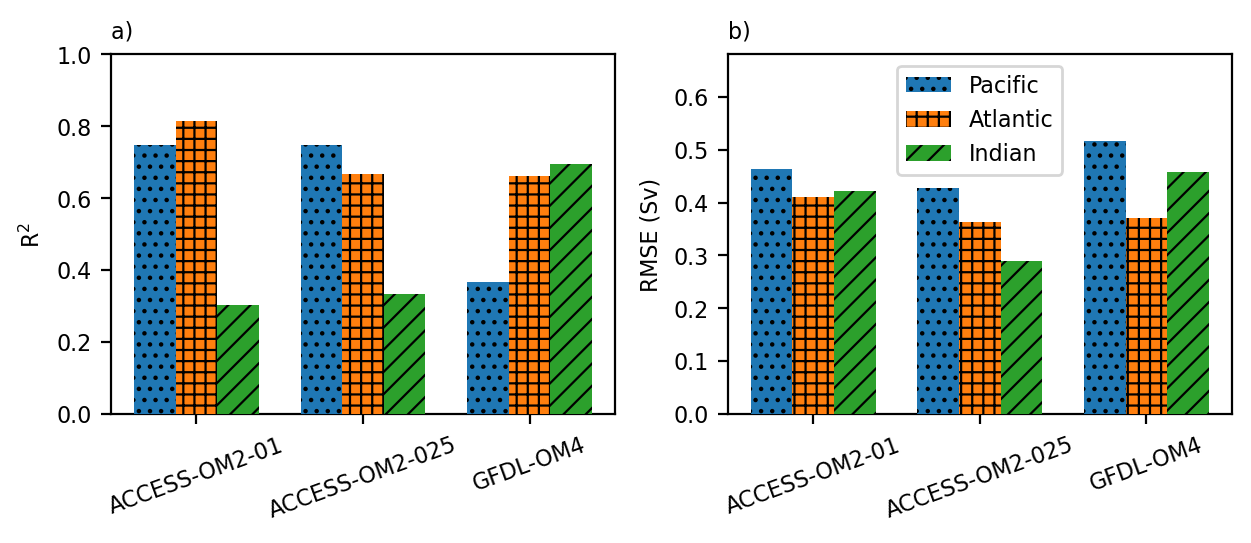

In [13]:
# Updating that figure, following Adele's suggestion to overwrite
R_model2 = {}

for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025):
    for bsi, bs in enumerate(basin_sets):
        if (expt == df.MOM6_025) and (bsi==0):
            X,Y,weights = XYweights_basinset(expt, bs, weight_names[0],mascon[0],overturning='_hr_37.08overturning.nc')
        else:
            X,Y,weights = XYweights_basinset(expt, bs, weight_names[0],mascon[0])
        
        R_model2[('r2',expt,bs)] = cg.noisy_filtered_R2(X,Y,weights,df.JPL_sigma,df.filters[df.fi],df.window_func[df.fi])
        R_model2[('mse',expt,bs)] = (cg.noisy_filtered_RMSE(X,Y,weights,df.JPL_sigma,df.filters[df.fi],df.window_func[df.fi])/1037/10**6)**2

fig, ax = plt.subplots(1,2,figsize=(160*mm,70*mm), sharex=True)
width = 1/4
for ri, rtype in enumerate(('r2','mse')):
    plt.sca(ax[ri])
    for bsi, bs in enumerate(basin_sets[:3]):
        plt.bar(np.arange(3)+bsi*width,
                [R_model2[(rtype,expt,bs)] for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025)],
                label=df.wb_names[bsi],width=width,linestyle='None',hatch=h[bsi],zorder=5)
    plt.xticks(np.array([0,1,2])+width,['ACCESS-OM2-01','ACCESS-OM2-025','GFDL-OM4'],rotation=20)
        
ax[0].set_title('a) ',loc='left',fontsize=df.titlefontsize)
ax[0].set_ylabel('R$^2$')
ax[0].set_ylim(0,1)
ax[1].set_title('b) ',loc='left',fontsize=df.titlefontsize)    
ax[1].set_ylim(0,0.68)
ax[1].set_ylabel('MSE (Sv)')
plt.subplots_adjust(wspace=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('/g/data/x77/jj8842/results/images/hr_model_choice(GFDL_pac_update).pdf')

In [14]:
for ri, rtype in enumerate(('r2','rmse')):
    for bsi, bs in enumerate(basin_sets[:3]):
        print(df.wb_names[bsi]+" "+rtype+":"+str(np.round([R_model2[(rtype,expt,bs)] for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025)],3)))
    #     plt.bar(np.arange(3)+bsi*width,
    #             [R_mascon[(rtype,i,bs)] for i in range(2,-1,-1)],
    #             label=df.wb_names[bsi],width=width,linestyle='None',hatch=h[bsi],zorder=5)

Pacific r2:[0.748 0.749 0.368]
Atlantic r2:[0.816 0.667 0.661]
Indian r2:[0.304 0.334 0.694]
Pacific rmse:[0.463 0.427 0.517]
Atlantic rmse:[0.411 0.364 0.371]
Indian rmse:[0.421 0.29  0.458]


### Changing graph to illustrate fraction/link/etc

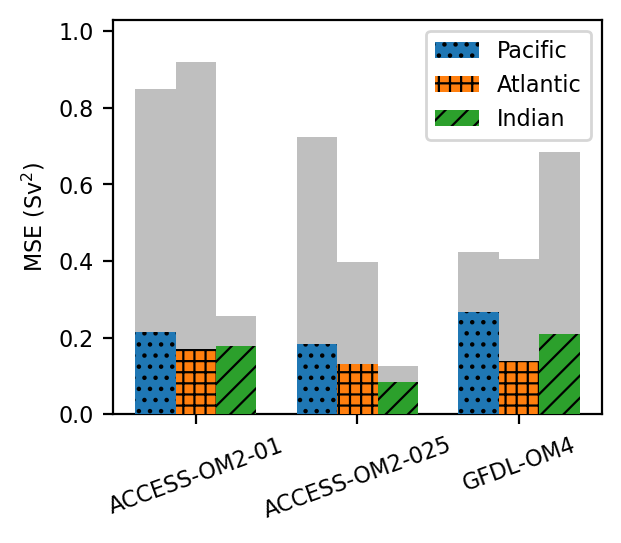

In [10]:
R_model2 = {}

for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025):
    for bsi, bs in enumerate(basin_sets):
        if (expt == df.MOM6_025) and (bsi==0):
            X,Y,weights = XYweights_basinset(expt, bs, weight_names[0],mascon[0],overturning='_hr_37.08overturning.nc')
        else:
            X,Y,weights = XYweights_basinset(expt, bs, weight_names[0],mascon[0])
        
        R_model2[('r2',expt,bs)] = cg.noisy_filtered_R2(X,Y,weights,df.JPL_sigma,df.filters[df.fi],df.window_func[df.fi])
        R_model2[('mse',expt,bs)] = (cg.noisy_filtered_RMSE(X,Y,weights,df.JPL_sigma,df.filters[df.fi],df.window_func[df.fi])/1037/10**6)**2
        R_model2[('var',expt,bs)] = (cg.noisy_filtered_RMSE(X,Y,weights*0,df.JPL_sigma,df.filters[df.fi],df.window_func[df.fi])/1037/10**6)**2

fig, ax = plt.subplots(1,1,figsize=(80*mm,70*mm), sharex=True)
width = 1/4
for ri, rtype in enumerate(('mse',)):
    #plt.sca(ax[ri])
    for bsi, bs in enumerate(basin_sets[:3]):
        if rtype=='mse':
           plt.bar(np.arange(3)+bsi*width,
                [R_model2[('var',expt,bs)] for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025)],
                width=width,linestyle='None',zorder=4,color='grey',alpha=0.5) 
        # else:
        #     plt.bar(np.arange(3)+bsi*width,
        #         [1 for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025)],
        #         width=width,linestyle='None',zorder=4,color='grey',alpha=0.5)  
        plt.bar(np.arange(3)+bsi*width,
                [R_model2[(rtype,expt,bs)] for expt in (df.ACCESS_OM2_01,df.ACCESS_OM2_025,df.MOM6_025)],
                label=df.wb_names[bsi],width=width,linestyle='None',hatch=h[bsi],zorder=5)
        
    plt.xticks(np.array([0,1,2])+width,['ACCESS-OM2-01','ACCESS-OM2-025','GFDL-OM4'],rotation=20)
        
# ax[0].set_title('a) ',loc='left',fontsize=df.titlefontsize)
# ax[0].set_ylabel('R$^2$ (fraction of variance captured)')
# ax[0].set_ylim(0,1.01)
#ax.set_title('b) ',loc='left',fontsize=df.titlefontsize)    
ax.set_ylim(0,1.03)
ax.set_ylabel('MSE (Sv$^2$)')
plt.subplots_adjust(wspace=0.25)
plt.legend()
plt.tight_layout()
plt.savefig('/g/data/x77/jj8842/results/images/hr_model_choice(GFDL_pac_update)MSEwithvariance.pdf')